In [4]:
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy as np

# Load Query images and coordinates

In [5]:
# load query images and covert BGR -> RGB

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return images

In [6]:
query_images = load_images_from_folder("Queries")

In [7]:
# load query coordinates, and transform them to list of integers

def get_coords(path):
    with open(path,'r') as f:
        a = f.read().splitlines()
        return [int(c) for c in str(a[0]).split()]

In [8]:
coords_queries_files = glob.glob("Queries/*.txt")
coords_queries = []
for i in range(len(coords_queries_files)):
    coords_queries.append(get_coords(coords_queries_files[i]))
# coords_queries

In [9]:
# crop image according to coordinate, saved in cropped_imgs

def crop_by_coords(img, coord):
    new_img = img[coord[1]:coord[1]+coord[3],coord[0]:coord[0]+coord[2]]
    return new_img

In [10]:
cropped_queries = []

for i in range(len(query_images)):
    cropped_queries.append(crop_by_coords(query_images[i], coords_queries[i]))

# Load Images and coordinates

In [11]:
images = load_images_from_folder("Images")
print(len(images))

5000


In [12]:
image_coords_path = glob.glob("Images/*.txt")
image_coords = []
for i in range(len(image_coords_path)):
    image_coords.append(get_coords(image_coords_path[i]))
print(len(image_coords))

2000


In [13]:
# images with coords

cropped_images = []

for i in range(len(image_coords)):
    cropped_images.append(crop_by_coords(images[i], image_coords[i]))

In [14]:
# image_all saves images with coords + images without coords
image_all = []
image_all = cropped_images.copy()
image_all = image_all + images[2000:]
print(len(image_all))

5000


# CNN - ResNet18 - Feature Extraction

In [12]:
import torch
from torch import nn
import torchvision
import torchvision.models as models
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm


def numpy2PIL(img):
    PIL_image = Image.fromarray(img.astype('uint8'), 'RGB')
    return PIL_image

In [13]:
new_cropped_queries = []
for img in cropped_queries:
    new_cropped_queries.append(numpy2PIL(img))
print('new_cropped_queries', len(new_cropped_queries))


new_images = []
for img in image_all:
    new_images.append(numpy2PIL(img))
print('new_images', len(new_images))

new_cropped_queries 20
new_images 5000


In [14]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

# resize the image to desired size
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_vector(image):
    
    t_img = transforms(image)
    features = torch.zeros(512)

    def copy_data(m, i, o):
        features.copy_(o.flatten())

    h = layer.register_forward_hook(copy_data)
    
    with torch.no_grad():                              
        model(t_img.unsqueeze(0))

    h.remove()
    return features

dist_all = []

for i in tqdm(range(len(new_cropped_queries))):
    query_img = new_cropped_queries[i]
    q_img = get_vector(query_img)
    question = "Q"+str(i+1)+":"
    dist_sub = []
    dist_single_row = []
    for j in tqdm(range(len(new_images))):
        target_img = new_images[j]
        t_img = get_vector(target_img)
        euclidena_dist = sum(((q_img - t_img)**2).reshape(512)).item()
        dist_sub.append([euclidena_dist, j+1])
    dist_sub.sort()
    
    img_num = [str(group[1]) for group in dist_sub]
    dist_single_row.append(question)
    dist_single_row = dist_single_row + img_num
    
    dist_all.append(dist_single_row)


import pickle

with open('cnn_dist_all_20_queries.pkl', 'wb') as f:
    pickle.dump(dist_all, f)

with open('examples/example_result/rankList_CNN_20_query.txt', 'w') as f:
    for i in range(len(new_cropped_queries)):
        for listitem in dist_all[i]:
            f.write('%s ' % listitem)
        f.write('\n')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

# Plot top 10 retrieved images

In [15]:
import pickle
with open('cnn_dist_all_20_queries.pkl', 'rb') as f:
    result_cnn = pickle.load(f)

In [16]:
len(result_cnn)

20

In [17]:
image_grid = []

for i in range(len(cropped_queries)):
    for j in range(10):
        image_grid.append(result_cnn[i][j+1])

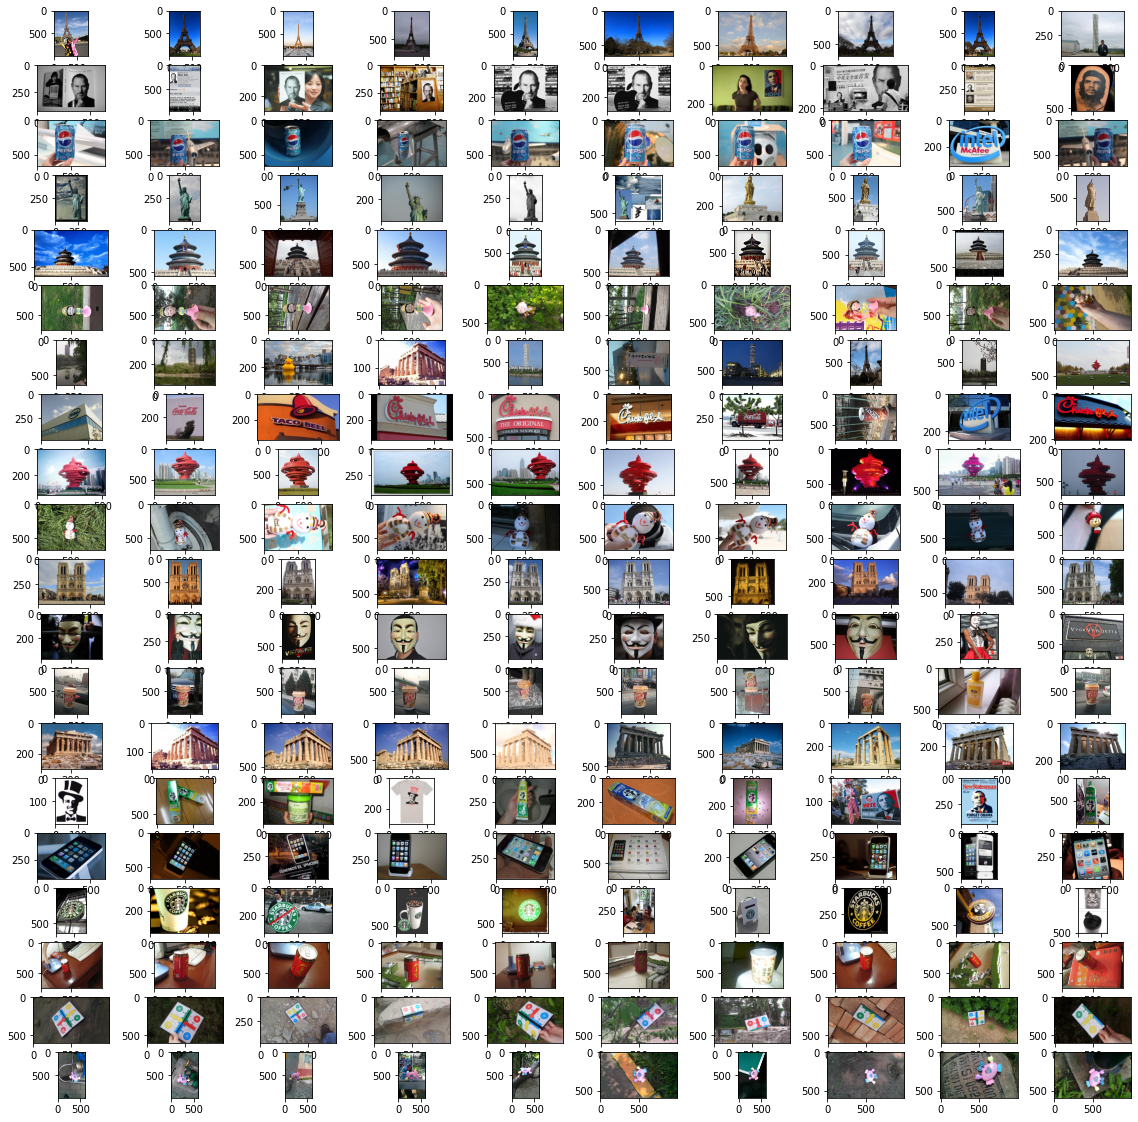

In [18]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=20
fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 20

for j in range(1, columns*rows +1):
    img = images[int(image_grid[j-1])-1]
    fig.add_subplot(rows, columns, j)
    plt.imshow(img)
plt.show()